In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from zipfile import ZipFile
import skimage.io
from PIL import Image
import seaborn as sns
from sklearn.manifold import TSNE
import random
import umap
from itertools import product

from mnist_generator import get_mnist_loaders
from mnistm_generator import get_mnistm_loaders
from DANN import *
from DA import *
from test import *
from train import *
from visualize import *
from util import *

# make sure using CPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

# mnist dataset

In [4]:
mnist_train_loader,mnist_eval_loader, mnist_test_loader = get_mnist_loaders(batch_size=128)

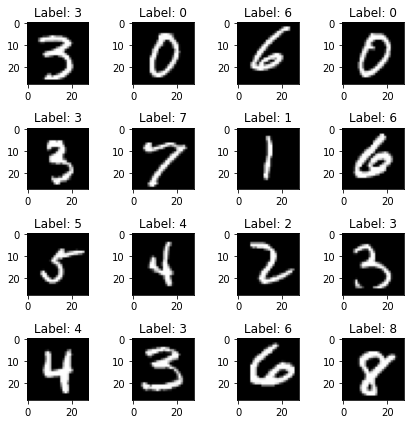

In [5]:

visualize_mnist(mnist_train_loader,4)

# mnistm dataset

In [6]:

mnistm_train_loader, mnistm_eval_loader,mnistm_test_loader = get_mnistm_loaders(batch_size=128)

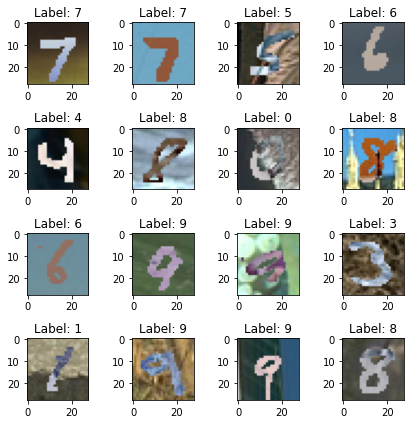

In [7]:
visualize_mnistm(mnistm_train_loader,4)

# visualization of representation of the original datasets

In [8]:
features, labels = generate_domain_datas(mnist_train_loader, mnistm_train_loader)

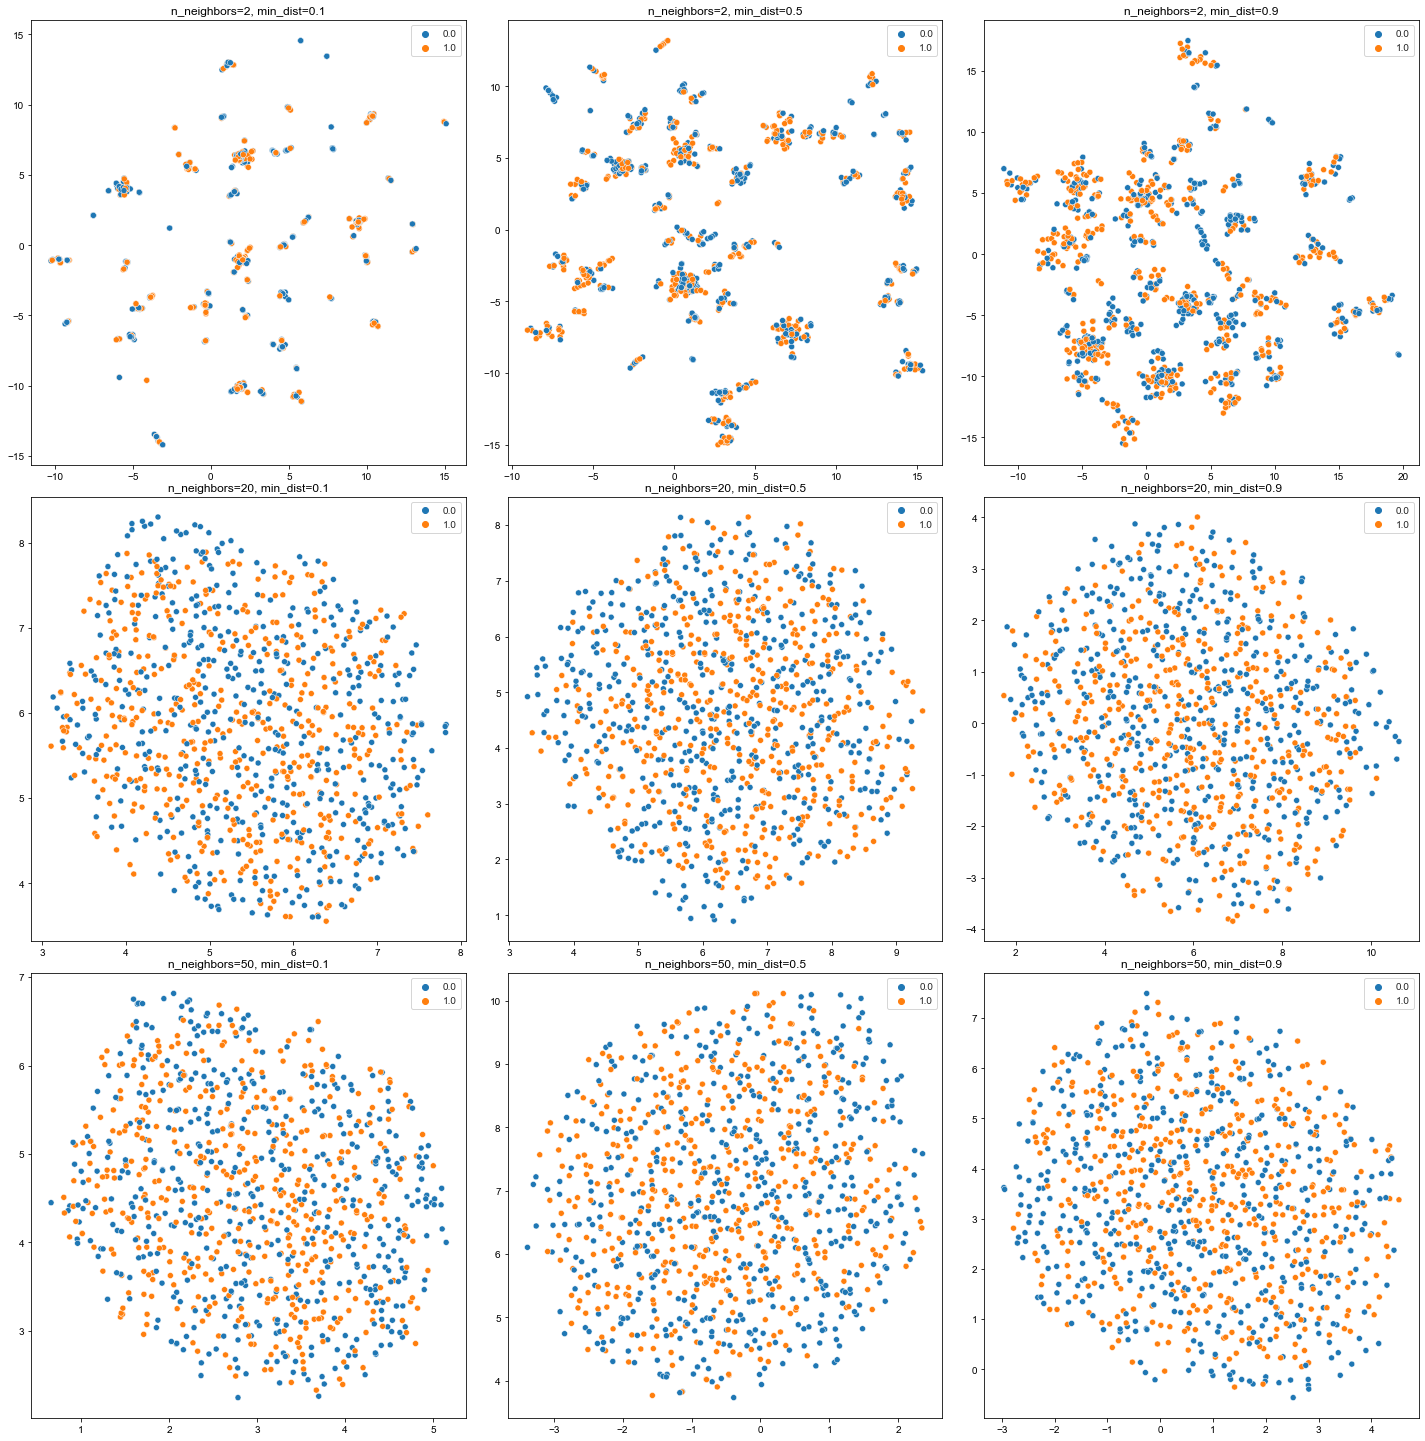

In [16]:
visualize_domain_UMAP(features, labels, size=1000)

# source only

In [8]:
source_accs,dann_source_only = DANNTrain_source_only(mnist_train_loader, 
                                                                    mnist_eval_loader,
                                                                    epochs=300,intervals=30)

30/300: source_acc: 0.9863666666666666
60/300: source_acc: 0.9905166666666667
90/300: source_acc: 0.9923666666666666
120/300: source_acc: 0.9942833333333333
150/300: source_acc: 0.99495
180/300: source_acc: 0.9956833333333334
210/300: source_acc: 0.99605
240/300: source_acc: 0.9964833333333334
270/300: source_acc: 0.9973333333333333
300/300: source_acc: 0.9972333333333333


In [26]:
save_model(dann_source_only,"./models/dann_source_only.pt")

In [12]:
source_acc = DANNAccuracy_source_only(dann_source_only, mnist_test_loader)
print(f'source_acc: {source_acc}')

source_acc: 0.9874


In [11]:
source_acc = DANNAccuracy_source_only(dann_source_only, mnistm_test_loader)
print(f'source_acc: {source_acc}')

source_acc: 0.4741


# target only

In [13]:
target_accs, dann_target_only = DANNTrain_source_only(mnistm_train_loader, mnistm_eval_loader, epochs=300,intervals=30)

30/300: source_acc: 0.9449666666666666
60/300: source_acc: 0.9515
90/300: source_acc: 0.9556333333333333
120/300: source_acc: 0.9564666666666667
150/300: source_acc: 0.9573333333333334
180/300: source_acc: 0.9590333333333333
210/300: source_acc: 0.9575666666666667
240/300: source_acc: 0.9596
270/300: source_acc: 0.9587
300/300: source_acc: 0.9604


In [25]:
save_model(dann_target_only,"./models/dann_target_only.pt")

In [15]:
source_acc = DANNAccuracy_source_only(dann_target_only, mnist_test_loader)
print(f'source_acc: {source_acc}')

source_acc: 0.8403


In [16]:
source_acc = DANNAccuracy_source_only(dann_target_only, mnistm_test_loader)
print(f'source_acc: {source_acc}')

source_acc: 0.9612


# classifier only

In [17]:
source_accs, target_accs, dann_classify_only = DANNTrain_classify_only(mnist_train_loader,mnist_eval_loader,mnistm_train_loader, mnistm_eval_loader, epochs=300,intervals=30)

30/300: source_acc: 0.98465, target_acc 0.9473666666666667
60/300: source_acc: 0.9884833333333334, target_acc 0.9552666666666667
90/300: source_acc: 0.99055, target_acc 0.95635
120/300: source_acc: 0.9921166666666666, target_acc 0.9589
150/300: source_acc: 0.9924666666666667, target_acc 0.95905
180/300: source_acc: 0.9937666666666667, target_acc 0.95835
210/300: source_acc: 0.9936, target_acc 0.96035
240/300: source_acc: 0.9943833333333333, target_acc 0.95975
270/300: source_acc: 0.9946833333333334, target_acc 0.9605833333333333
300/300: source_acc: 0.9946666666666667, target_acc 0.96115


In [24]:
save_model(dann_classify_only,'./models/dann_classify_only.pt')

In [20]:
source_acc, target_acc  = DANNAccuracy_classify_only(dann_classify_only, mnist_test_loader,mnistm_test_loader)
print(f'source_acc: {source_acc}, target_acc {target_acc}')

source_acc: 0.987, target_acc 0.9602


In [21]:
total_x = np.r_[np.stack([np.r_[x[0],x[0],x[0]] for x in mnist_train_loader.dataset]).reshape(60000,-1),
                  np.stack([x[0] for x in mnistm_train_loader.dataset]).reshape(60000,-1)]
total_y = np.r_[np.array([0 for x in mnist_train_loader.dataset]),
                  np.array([1 for x in mnistm_train_loader.dataset])]

In [22]:
def Proxy_A_distance(features, labels):
    index = np.random.randint(0,120000,20000)
    x_train = features[index[:10000]]
    y_train = labels[index[:10000]]
    x_test = features[index[10000:]]
    y_test = labels[index[10000:]]
    clf = svm.SVC()
    clf.fit(x_train,y_train)
    predicted = clf.predict(x_test)
    err = np.mean(np.abs(predicted-y_test))
    proxy = 2*(1-2*err)
    return proxy

In [23]:
proxy = Proxy_A_distance(total_x,total_y)
print(proxy)

1.9896


# build DANN model

In [ ]:
source_accs, target_accs, domain_accs, dann = DANNTrain(
      mnist_train_loader,
      mnistm_train_loader,
      mnist_eval_loader,
      mnistm_eval_loader,
      epochs=300,
      intervals = 30)

In [27]:
# USE WHEN YOU WANT TO LOAD THE SAVED MODEL
dann = load_DANN("./models/dann_v1.pt")

In [28]:
s_acc, t_acc, domain_acc = DANNAccuracy(dann, mnist_test_loader,mnistm_test_loader)
print(f'source_acc: {s_acc},target_acc: {t_acc}, domain_acc: {domain_acc}')

source_acc: 0.9755,target_acc: 0.9084, domain_acc: 0.5591


In [29]:
features, labels = generate_domain_datas_from_dann(dann, mnist_train_loader,mnistm_train_loader)

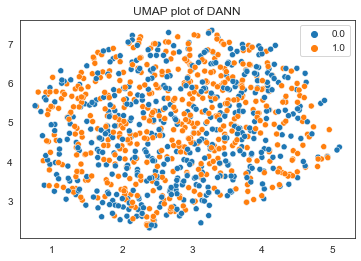

In [35]:
visualize_domain_UMAP(features, labels,name="UMAP plot of DANN",size=1000)

In [36]:
proxy = Proxy_A_distance(np.array(features),np.array(labels))
print(proxy)

1.7668000012636185


In [22]:
# USE WHEN YOU WANT TO SAVE OR UPDATE THE MODEL
save_model(dann,"./models/dann_v1.pt")

# Denoising Autoencoders

In [23]:
loss_arr, autoencoder = DATrain(mnist_train_loader, mnistm_train_loader, mnist_eval_loader, mnistm_eval_loader,1000,300,intervals=30)

30/300: avg_loss:0.024014877155423164
60/300: avg_loss:0.020862631499767303
90/300: avg_loss:0.017290571704506874
120/300: avg_loss:0.01766866073012352
150/300: avg_loss:0.018362030386924744
180/300: avg_loss:0.018653718754649162
210/300: avg_loss:0.019026244059205055
240/300: avg_loss:0.01924067549407482
270/300: avg_loss:0.0189040657132864
300/300: avg_loss:0.01968919113278389


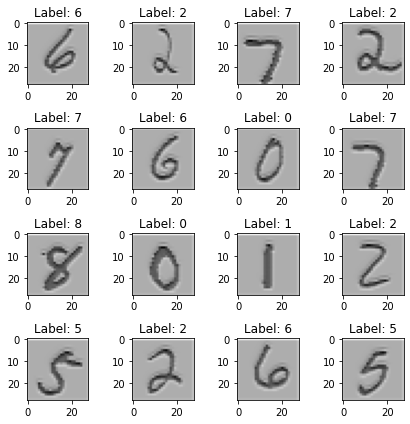

In [24]:
visualize_from_DA(autoencoder,mnist_train_loader,4)

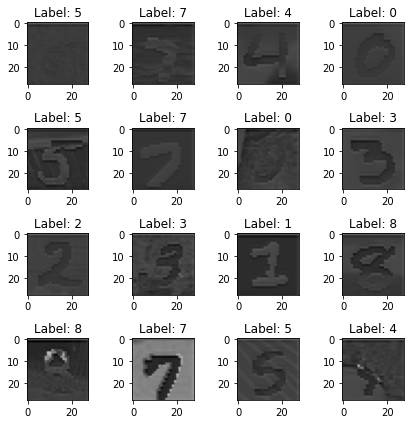

In [25]:
visualize_from_DA(autoencoder,mnistm_train_loader,4)

In [26]:
save_model(autoencoder,"./models/da_v1.pt")

In [13]:
autoencoder = DenoisingAutoencoder(100)
autoencoder = load_DA("./models/da_v1.pt")

In [14]:
features, labels = generate_domain_datas_DA(autoencoder, mnist_train_loader,mnistm_train_loader)

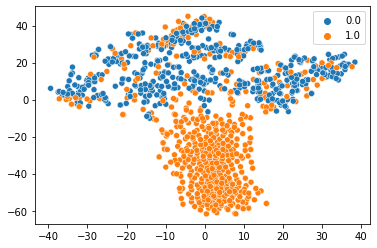

In [29]:
visualize_domain_tSNE(features, labels,size=1000)

In [15]:
proxy = Proxy_A_distance(np.array(features),np.array(labels))
print(proxy)

1.9751999992877245


# DANN with encoder from autoencoder

In [21]:
source_accs, target_accs, domain_accs, dann_da=DANNTrain_with_DA(autoencoder, 
                                                                                mnist_train_loader, 
                                                                                mnistm_train_loader, 
                                                                                mnist_eval_loader, 
                                                                                mnistm_eval_loader, 
                                                                                300,30)

30/300: source_acc: 0.9696833333333333,target_acc: 0.8150833333333334, domain_acc: 0.6431666666666667
60/300: source_acc: 0.9741166666666666,target_acc: 0.8682666666666666, domain_acc: 0.5753416666666666
90/300: source_acc: 0.9788,target_acc: 0.8824666666666666, domain_acc: 0.5756
120/300: source_acc: 0.9809666666666667,target_acc: 0.8935, domain_acc: 0.5674166666666667
150/300: source_acc: 0.9831333333333333,target_acc: 0.8962, domain_acc: 0.559025
180/300: source_acc: 0.9860833333333333,target_acc: 0.8994833333333333, domain_acc: 0.5582333333333334
210/300: source_acc: 0.9857833333333333,target_acc: 0.90115, domain_acc: 0.5569666666666667
240/300: source_acc: 0.9876666666666667,target_acc: 0.90135, domain_acc: 0.562025
270/300: source_acc: 0.9871833333333333,target_acc: 0.9035, domain_acc: 0.5527833333333333
300/300: source_acc: 0.9885166666666667,target_acc: 0.90465, domain_acc: 0.5591583333333333


In [22]:
save_model(dann_da, "./models/dann_da_v1.pt")

In [23]:
def load_DANN_v2(name,isGPU=True):
    dann = DANN_v2()
    if (isGPU):
        dann = dann.to(device)
    dann.load_state_dict(torch.load(name))
    return dann

In [25]:
dann_da = load_DANN_v2("./models/dann_da_v1.pt")

In [11]:
DANNAccuracy_with_DA(dann_da,autoencoder, mnist_test_loader, mnistm_test_loader)

(0.9741, 0.9053, 0.56605)

In [26]:
features, labels = generate_domain_datas_from_extractor_with_DA(dann_da,autoencoder, mnist_train_loader,mnistm_train_loader)

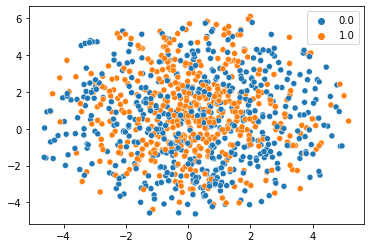

In [50]:
visualize_domain_tSNE(features, labels,size=1000)

In [27]:
proxy = Proxy_A_distance(np.array(features),np.array(labels))
print(proxy)

1.5920000076293945
